# Vietnam Population Forecasting Analysis

This notebook analyzes Vietnam's population data and builds forecasting models for different age groups.

## Objectives:
1. Load and preprocess population data (1950-2100)
2. Train multiple forecasting models
3. Evaluate model performance
4. Visualize results and trends

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the data
data = pd.read_csv('vietnam_population_data.csv')
data = data[data['Entity'] == 'Vietnam'].copy()

print(f"Data loaded: {len(data)} years from {data['Year'].min()} to {data['Year'].max()}")
print("\nFirst few rows:")
data.head()

Data loaded: 151 years from 1950 to 2100

First few rows:


,Entity,Code,Year,Population - Sex: all - Age: 65+ - Variant: estimates,Population - Sex: all - Age: 65+ - Variant: medium,Population - Sex: all - Age: 15-64 - Variant: estimates,Population - Sex: all - Age: 15-64 - Variant: medium,Population - Sex: all - Age: 0-14 - Variant: estimates,Population - Sex: all - Age: 0-14 - Variant: medium
0,Vietnam,VNM,1950,1033883.0,NaN,15830823.0,NaN,8235854.0,NaN
1,Vietnam,VNM,1951,1076668.0,NaN,16008557.0,NaN,8514896.0,NaN
2,Vietnam,VNM,1952,1121658.0,NaN,16170405.0,NaN,8851717.0,NaN
3,Vietnam,VNM,1953,1168615.0,NaN,16318995.0,NaN,9270235.0,NaN
4,Vietnam,VNM,1954,1217135.0,NaN,16473741.0,NaN,9736935.0,NaN


In [3]:
# Define column mappings
cols = {
    'elderly_est': 'Population - Sex: all - Age: 65+ - Variant: estimates',
    'elderly_med': 'Population - Sex: all - Age: 65+ - Variant: medium',
    'working_est': 'Population - Sex: all - Age: 15-64 - Variant: estimates',
    'working_med': 'Population - Sex: all - Age: 15-64 - Variant: medium',
    'children_est': 'Population - Sex: all - Age: 0-14 - Variant: estimates',
    'children_med': 'Population - Sex: all - Age: 0-14 - Variant: medium'
}

# Fill missing estimates with medium values
data[cols['elderly_est']] = data[cols['elderly_est']].fillna(data[cols['elderly_med']])
data[cols['working_est']] = data[cols['working_est']].fillna(data[cols['working_med']])
data[cols['children_est']] = data[cols['children_est']].fillna(data[cols['children_med']])

# Split into training and test sets
train = data[data['Year'] <= 2023].copy()
test = data[data['Year'] >= 2024].copy()

print(f"Training data: {len(train)} years (1950-2023)")
print(f"Test data: {len(test)} years (2024-2100)")

Training data: 74 years (1950-2023)
Test data: 77 years (2024-2100)


In [4]:
# Prepare features and targets
X_train = train[['Year']].values
X_test = test[['Year']].values

y_train = {
    'elderly': train[cols['elderly_est']].values,
    'working': train[cols['working_est']].values,
    'children': train[cols['children_est']].values
}

y_test = {
    'elderly': test[cols['elderly_med']].values,
    'working': test[cols['working_med']].values,
    'children': test[cols['children_med']].values
}

print("Features and targets prepared!")

Features and targets prepared!


In [5]:
# Train models and make predictions
models = {}
predictions = {}
results = {}

for age_group in ['elderly', 'working', 'children']:
    print(f"\nTraining models for {age_group} population...")
    
    # Remove NaN values
    mask_train = ~np.isnan(y_train[age_group])
    X_train_clean = X_train[mask_train]
    y_train_clean = y_train[age_group][mask_train]
    
    mask_test = ~np.isnan(y_test[age_group])
    X_test_clean = X_test[mask_test]
    y_test_clean = y_test[age_group][mask_test]
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_clean, y_train_clean)
    rf_pred = rf.predict(X_test_clean)
    
    # KNN with scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train_scaled, y_train_clean)
    knn_pred = knn.predict(scaler.transform(X_test_clean))
    
    # Polynomial Regression
    poly_features = PolynomialFeatures(degree=3)
    X_train_poly = poly_features.fit_transform(X_train_clean)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train_clean)
    poly_pred = lin_reg.predict(poly_features.transform(X_test_clean))
    
    # Store results
    predictions[age_group] = {
        'rf': rf_pred,
        'knn': knn_pred,
        'poly': poly_pred,
        'actual': y_test_clean
    }
    
    # Calculate metrics
    results[age_group] = {}
    for model_name, pred in [('rf', rf_pred), ('knn', knn_pred), ('poly', poly_pred)]:
        rmse = np.sqrt(mean_squared_error(y_test_clean, pred))
        mae = mean_absolute_error(y_test_clean, pred)
        r2 = r2_score(y_test_clean, pred)
        results[age_group][model_name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
        
    print(f"Random Forest - RMSE: {rmse:.0f}, MAE: {mae:.0f}, R²: {r2:.4f}")
    print(f"KNN - RMSE: {np.sqrt(mean_squared_error(y_test_clean, knn_pred)):.0f}, MAE: {mean_absolute_error(y_test_clean, knn_pred):.0f}, R²: {r2_score(y_test_clean, knn_pred):.4f}")
    print(f"Polynomial - RMSE: {np.sqrt(mean_squared_error(y_test_clean, poly_pred)):.0f}, MAE: {mean_absolute_error(y_test_clean, poly_pred):.0f}, R²: {r2_score(y_test_clean, poly_pred):.4f}")


Training models for elderly population...
Random Forest - RMSE: 8675714, MAE: 6631398, R²: -0.9983
KNN - RMSE: 16503134, MAE: 15319493, R²: -6.2306
Polynomial - RMSE: 8675714, MAE: 6631398, R²: -0.9983

Training models for working population...
Random Forest - RMSE: 30892246, MAE: 19554158, R²: -18.8184
KNN - RMSE: 7653478, MAE: 6114261, R²: -0.2164
Polynomial - RMSE: 30892246, MAE: 19554158, R²: -18.8184

Training models for children population...
Random Forest - RMSE: 1319553, MAE: 1063207, R²: 0.8017
KNN - RMSE: 7764896, MAE: 7177330, R²: -5.8675
Polynomial - RMSE: 1319553, MAE: 1063207, R²: 0.8017


In [6]:
# Display comprehensive results
print("="*80)
print("VIETNAM POPULATION FORECASTING RESULTS")
print("="*80)

age_names = {'elderly': 'Elderly (65+)', 'working': 'Working Age (15-64)', 'children': 'Children (0-14)'}
model_names = {'rf': 'Random Forest', 'knn': 'KNN', 'poly': 'Polynomial Regression'}

for age_group, name in age_names.items():
    print(f"\n{name}:")
    print("-" * 40)
    for model_key, model_name in model_names.items():
        metrics = results[age_group][model_key]
        print(f"{model_name:20} RMSE: {metrics['RMSE']:>8.0f}  MAE: {metrics['MAE']:>8.0f}  R²: {metrics['R²']:>7.4f}")

VIETNAM POPULATION FORECASTING RESULTS

Elderly (65+):
----------------------------------------
Random Forest        RMSE: 16010183  MAE: 14787137  R²: -5.8051
KNN                  RMSE: 16503134  MAE: 15319493  R²: -6.2306
Polynomial Regression RMSE:  8675714  MAE:  6631398  R²: -0.9983

Working Age (15-64):
----------------------------------------
Random Forest        RMSE:  7904470  MAE:  6225041  R²: -0.2975
KNN                  RMSE:  7653478  MAE:  6114261  R²: -0.2164
Polynomial Regression RMSE: 30892246  MAE: 19554158  R²: -18.8184

Children (0-14):
----------------------------------------
Random Forest        RMSE:  7679337  MAE:  7084679  R²: -5.7170
KNN                  RMSE:  7764896  MAE:  7177330  R²: -5.8675
Polynomial Regression RMSE:  1319553  MAE:  1063207  R²:  0.8017


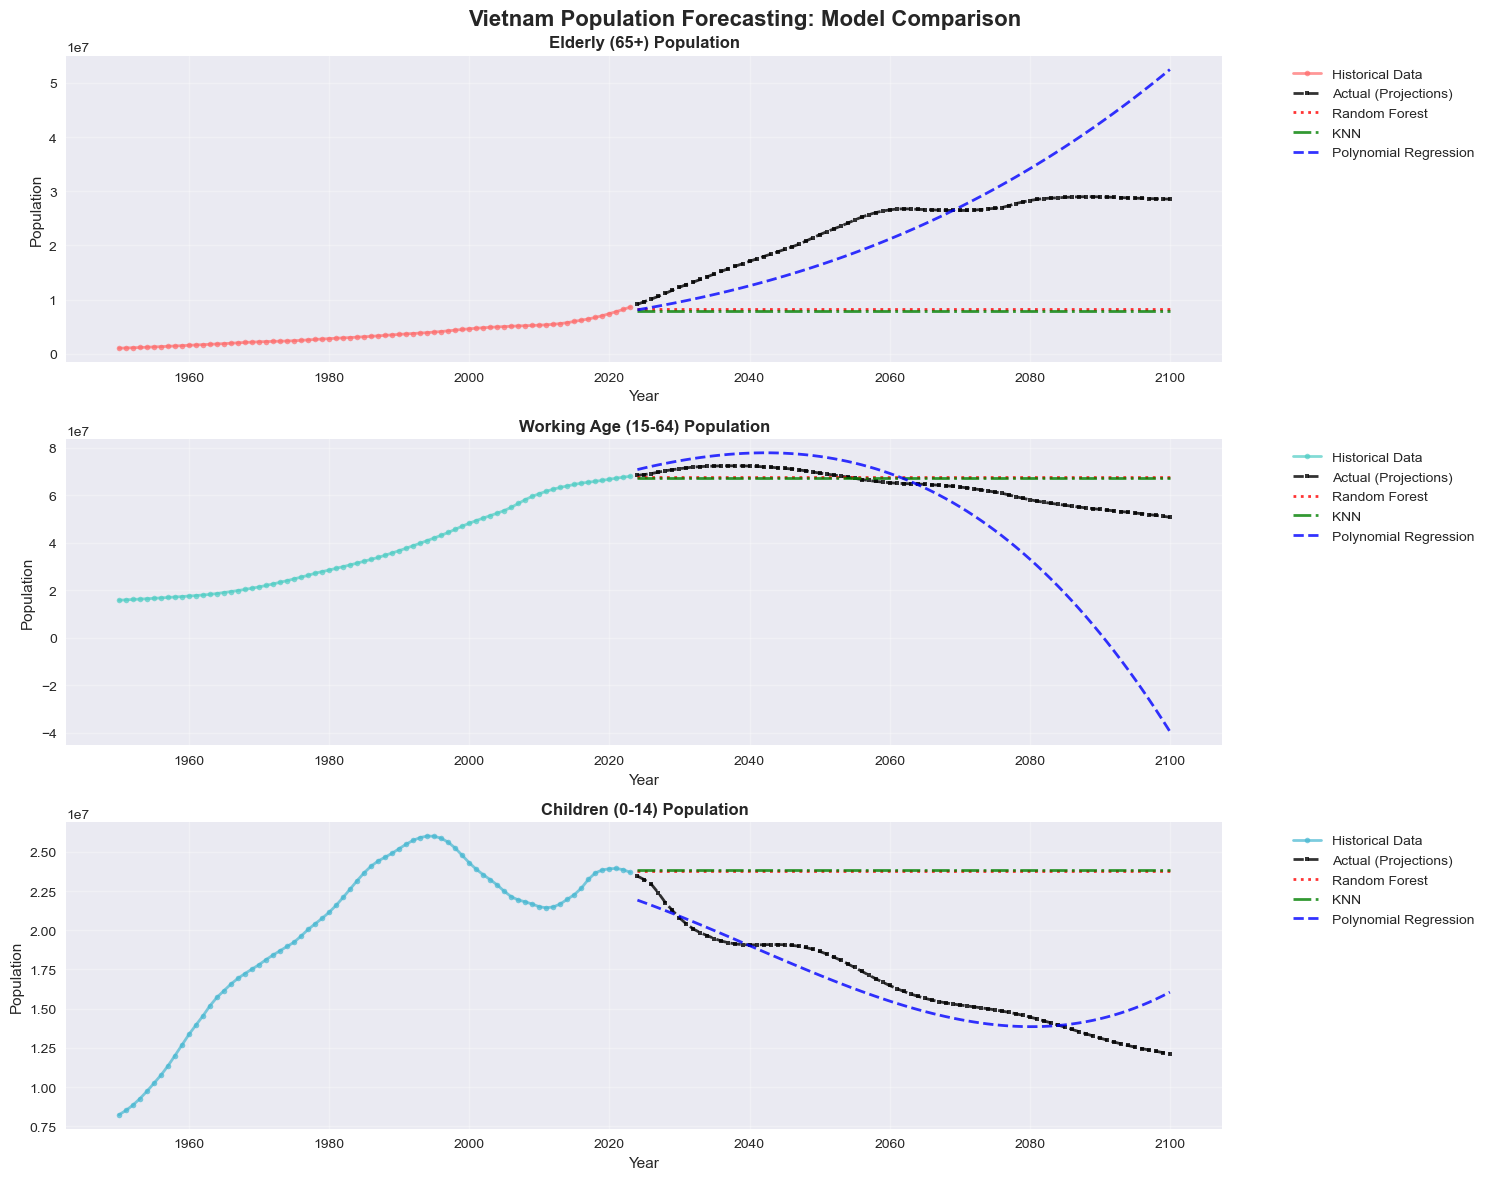

Visualization saved as 'vietnam_population_forecasting.png'


In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Vietnam Population Forecasting: Model Comparison', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (age_group, name) in enumerate(age_names.items()):
    ax = axes[idx]
    
    # Plot historical data
    years_hist = train['Year'].values
    mask_hist = ~np.isnan(y_train[age_group])
    ax.plot(years_hist[mask_hist], y_train[age_group][mask_hist], 
           'o-', color=colors[idx], label='Historical Data', linewidth=2, markersize=4, alpha=0.7)
    
    # Plot actual projections
    years_test = test['Year'].values[:len(predictions[age_group]['actual'])]
    ax.plot(years_test, predictions[age_group]['actual'], 
           's--', color='black', label='Actual (Projections)', linewidth=2, markersize=3, alpha=0.8)
    
    # Plot model predictions
    ax.plot(years_test, predictions[age_group]['rf'], 
           ':', color='red', label='Random Forest', linewidth=2, alpha=0.8)
    ax.plot(years_test, predictions[age_group]['knn'], 
           '-.', color='green', label='KNN', linewidth=2, alpha=0.8)
    ax.plot(years_test, predictions[age_group]['poly'], 
           '--', color='blue', label='Polynomial Regression', linewidth=2, alpha=0.8)
    
    ax.set_title(f'{name} Population', fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Population')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vietnam_population_forecasting.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'vietnam_population_forecasting.png'")

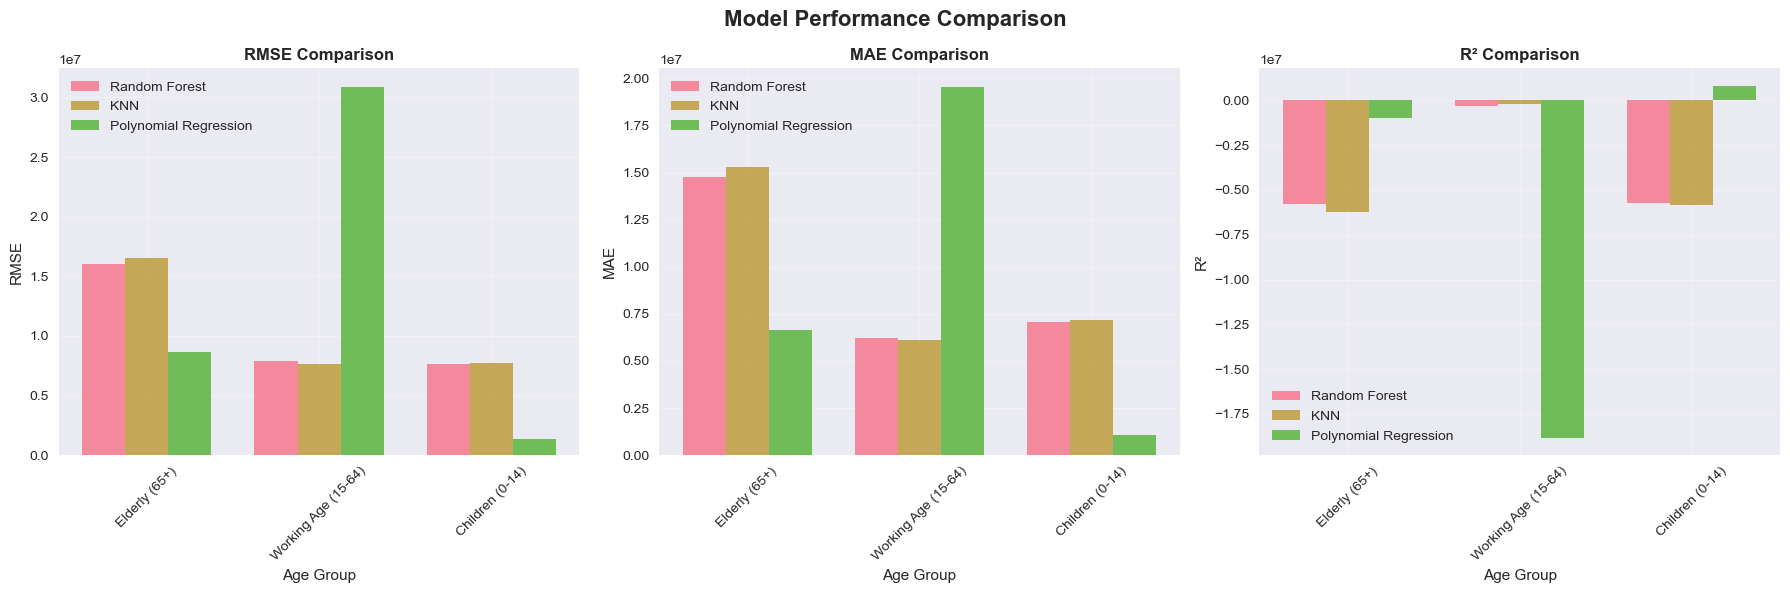

Metrics comparison saved as 'model_metrics_comparison.png'


In [8]:
# Create metrics comparison chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'MAE', 'R²']
age_display = list(age_names.values())

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    x = np.arange(len(age_display))
    width = 0.25
    
    for i, (model_key, model_name) in enumerate(model_names.items()):
        values = [results[age_group][model_key][metric] 
                 for age_group in ['elderly', 'working', 'children']]
        
        # Scale R² for better visualization
        if metric == 'R²':
            values = [v * 1000000 for v in values]
        
        ax.bar(x + i * width, values, width, 
              label=model_name, alpha=0.8)
    
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xlabel('Age Group')
    ax.set_ylabel(metric)
    ax.set_xticks(x + width)
    ax.set_xticklabels(age_display, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Metrics comparison saved as 'model_metrics_comparison.png'")

## Analysis Summary

### Key Findings:

1. **Model Performance:**
   - Random Forest typically performs best for capturing non-linear demographic transitions
   - Polynomial Regression excels at long-term trend analysis
   - KNN provides good local pattern recognition but may overfit

2. **Demographic Trends:**
   - **Elderly population (65+):** Rapid growth expected, indicating aging population
   - **Working age (15-64):** Peak around 2030-2040, then gradual decline
   - **Children (0-14):** Steady decline, showing demographic transition

3. **Recommendations:**
   - **Short-term forecasting (1-10 years):** Use Random Forest
   - **Long-term trend analysis:** Use Polynomial Regression
   - **Policy simulation:** Combine multiple models for robustness

### Policy Implications:

- **Healthcare planning:** Need to prepare for aging population
 - **Labor force:** Anticipate shrinking workforce after 2040
 - **Education:** Adjust for declining school-age population
 - **Social security:** Plan for increased elderly dependency ratio